This first part is only needed as we have to mock VASP here as we cannot run it directly in a jupyter notebook:

In [1]:
from mock_vasp import TEST_DIR, mock_vasp


from mock_vasp import TEST_DIR, mock_vasp

ref_paths = {
    "phonon static 1/1": "Si_qha_2/phonon_static_1_1",
    "static": "Si_qha_2/static",
    "tight relax 1 EOS equilibrium relaxation": "Si_qha_2/tight_relax_1",
    "tight relax 2 EOS equilibrium relaxation": "Si_qha_2/tight_relax_2",
    "tight relax 1 deformation 0": "Si_qha_2/tight_relax_1_d0",
    "tight relax 1 deformation 1": "Si_qha_2/tight_relax_1_d1",
    "tight relax 1 deformation 2": "Si_qha_2/tight_relax_1_d2",
    "tight relax 1 deformation 3": "Si_qha_2/tight_relax_1_d3",
    "tight relax 1 deformation 4": "Si_qha_2/tight_relax_1_d4",
    "tight relax 1 deformation 5": "Si_qha_2/tight_relax_1_d5",
    "tight relax 2 deformation 0": "Si_qha_2/tight_relax_2_d0",
    "tight relax 2 deformation 1": "Si_qha_2/tight_relax_2_d1",
    "tight relax 2 deformation 2": "Si_qha_2/tight_relax_2_d2",
    "tight relax 2 deformation 3": "Si_qha_2/tight_relax_2_d3",
    "tight relax 2 deformation 4": "Si_qha_2/tight_relax_2_d4",
    "tight relax 2 deformation 5": "Si_qha_2/tight_relax_2_d5",
    "dft phonon static eos deformation 1":"Si_qha_2/dft_phonon_static_eos_deformation_1",
    "dft phonon static eos deformation 2":"Si_qha_2/dft_phonon_static_eos_deformation_2",
    "dft phonon static eos deformation 3":"Si_qha_2/dft_phonon_static_eos_deformation_3",
    "dft phonon static eos deformation 4":"Si_qha_2/dft_phonon_static_eos_deformation_4",
    "dft phonon static eos deformation 5":"Si_qha_2/dft_phonon_static_eos_deformation_5",
    "dft phonon static eos deformation 6":"Si_qha_2/dft_phonon_static_eos_deformation_6",
    "dft phonon static eos deformation 7":"Si_qha_2/dft_phonon_static_eos_deformation_7",
    "dft phonon static 1/1 eos deformation 1": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_1",
    "dft phonon static 1/1 eos deformation 2": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_2",
    "dft phonon static 1/1 eos deformation 3": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_3",
    "dft phonon static 1/1 eos deformation 4": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_4",
    "dft phonon static 1/1 eos deformation 5": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_5",
    "dft phonon static 1/1 eos deformation 6": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_6",
    "dft phonon static 1/1 eos deformation 7": "Si_qha_2/dft_phonon_static_1_1_eos_deformation_7",
}


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


QHA workflow

This tutorial will make use of a quasi-harmonic workflow that allows to include volume-dependent anharmonicity into the calculation of phonon free energies. Please check out the paper by Togo to learn about the exact implementation as we will rely on Phonopy to perform the quasi-harmonic approximation. https://doi.org/10.7566/JPSJ.92.012001. At the moment, we perform harmonic free energy calculation along a volume curve to arrive at free energy-volume curves that are the starting point for the quasi-harmonic approximation.

## Let's run the workflow
Now, we load a structure and other important functions and classes for running the qha workflow.

In [2]:
from jobflow import JobStore, run_locally
from maggma.stores import MemoryStore
from pymatgen.core import Structure

from atomate2.vasp.flows.qha import QhaMaker

job_store = JobStore(MemoryStore(), additional_stores={"data": MemoryStore()})
si_structure = Structure.from_file(TEST_DIR / "structures" / "Si_diamond.cif")

Then one can use the `QhaMaker` to generate a `Flow`. First, the structure will be optimized than the structures will be optimized at constant volume along an energy volume curve. Please make sure the structural optimizations are tight enough. At each of these volumes, a phonon run will then be performed. The quasi-harmonic approximation is only valid if the harmonic phonon curves don't show any imaginary modes. However, for testing, you can also switch off this option.

Before we start the quasi-harmonic workflow, we adapt the first relaxation, the relaxation with different volumes and the static runs for the phonon calculation. As we deal with Si, we will not add the non-analytical term correction.

In [3]:
from atomate2.vasp.flows.core import DoubleRelaxMaker
from atomate2.vasp.jobs.core import TightRelaxMaker
from atomate2.vasp.sets.core import StaticSetGenerator, TightRelaxSetGenerator
from atomate2.vasp.flows.phonons import PhononMaker
from atomate2.vasp.jobs.phonons import PhononDisplacementMaker
phonon_bulk_relax_maker_isif3 = DoubleRelaxMaker.from_relax_maker(
    TightRelaxMaker(
        run_vasp_kwargs={"handlers": ()},
        input_set_generator=TightRelaxSetGenerator(
            user_incar_settings={
                "GGA": "PE",
                "ISPIN": 1,
                "KSPACING": 0.1,
                # "EDIFFG": 1e-5,
                "ALGO": "Normal",
                "LAECHG": False,
                "ISMEAR": 0,
                "ENCUT": 700,
                "IBRION": 1,
                "ISYM": 0,
                "SIGMA": 0.05,
                "LCHARG": False,  # Do not write the CHGCAR file
                "LWAVE": False,  # Do not write the WAVECAR file
                "LVTOT": False,  # Do not write LOCPOT file
                "LORBIT": None,  # No output of projected or partial DOS in EIGENVAL, PROCAR and DOSCAR
                "LOPTICS": False,  # No PCDAT file
                "LREAL": False,
                "ISIF": 3,
                # to be removed
                "NPAR": 4,
            }
        ),
    )
)

phonon_displacement_maker = PhononDisplacementMaker(
    run_vasp_kwargs={"handlers": ()}, input_set_generator=StaticSetGenerator(
        user_incar_settings={
            "GGA": "PE",
            "IBRION": -1,
            "ISPIN": 1,
            "ISMEAR": 0,
            "ISIF": 3,
            "ENCUT": 700,
            "EDIFF": 1e-7,
            "LAECHG": False,
            "LREAL": False,
            "ALGO": "Normal",
            "NSW": 0,
            "LCHARG": False,  # Do not write the CHGCAR file
            "LWAVE": False,  # Do not write the WAVECAR file
            "LVTOT": False,  # Do not write LOCPOT file
            "LORBIT": None,  # No output of projected or partial DOS in EIGENVAL, PROCAR and DOSCAR
            "LOPTICS": False,  # No PCDAT file
            "SIGMA": 0.05,
            "ISYM": 0,
            "KSPACING": 0.1,
            "NPAR": 4,
        },
        auto_ispin=False,
    )
)



phonon_bulk_relax_maker_isif4 = DoubleRelaxMaker.from_relax_maker(
    TightRelaxMaker(
        run_vasp_kwargs={"handlers": ()},
        input_set_generator=TightRelaxSetGenerator(
            user_incar_settings={
                "GGA": "PE",
                "ISPIN": 1,
                "KSPACING": 0.1,
                "ALGO": "Normal",
                "LAECHG": False,
                "ISMEAR": 0,
                "ENCUT": 700,
                "IBRION": 1,
                "ISYM": 0,
                "SIGMA": 0.05,
                "LCHARG": False,  # Do not write the CHGCAR file
                "LWAVE": False,  # Do not write the WAVECAR file
                "LVTOT": False,  # Do not write LOCPOT file
                "LORBIT": None,  # No output of projected or partial DOS in EIGENVAL, PROCAR and DOSCAR
                "LOPTICS": False,  # No PCDAT file
                "LREAL": False,
                "ISIF": 4,
                # to be removed
                "NPAR": 4,
            }
        ),
    )
)

phonon_displacement_maker.name = "dft phonon static"



In [4]:
flow = QhaMaker(
    initial_relax_maker=phonon_bulk_relax_maker_isif3,
    eos_relax_maker=phonon_bulk_relax_maker_isif4,
    min_length=10,
    phonon_maker=PhononMaker(generate_frequencies_eigenvectors_kwargs={"tmin": 0, "tmax": 1000, "tstep": 10},

                             bulk_relax_maker=None,
                             born_maker=None,
                             static_energy_maker=phonon_displacement_maker,
                             phonon_displacement_maker=phonon_displacement_maker),
    linear_strain=(-0.15, 0.15),
    number_of_frames=6,
    pressure=None,
    t_max=None,
    ignore_imaginary_modes=False,
    skip_analysis=False,
    eos_type="vinet"
).make(structure=si_structure)

2025-02-12 19:47:06,802 INFO Started executing jobs locally
2025-02-12 19:47:06,819 INFO Starting job - tight relax 1 EOS equilibrium relaxation (89034fda-0616-4fa1-98cf-12554839513f)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1219: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:08,028 INFO Finished job - tight relax 1 EOS equilibrium relaxation (89034fda-0616-4fa1-98cf-12554839513f)
2025-02-12 19:47:08,029 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:08,030 INFO Starting job - tight relax 2 EOS equilibrium relaxation (aa677af4-d8ef-4a3f-9436-e5ad7b615712)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-08-030242-19998/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:09,400 INFO Finished job - tight relax 2 EOS equilibrium relaxation (aa677af4-d8ef-4a3f-9436-e5ad7b615712)
2025-02-12 19:47:09,400 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:09,401 INFO Starting job - apply_strain_to_structure (42396e00-786d-4a80-844f-dff18a2dbc22)
2025-02-12 19:47:09,435 INFO Finished job - apply_strain_to_structure (42396e00-786d-4a80-844f-dff18a2dbc22)
2025-02-12 19:47:09,437 INFO Starting job - tight relax 1 deformation 0 (e5c8dad2-8aac-49ca-a241-230316bfe4dc)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-09-436859-95935/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:10,450 INFO Finished job - tight relax 1 deformation 0 (e5c8dad2-8aac-49ca-a241-230316bfe4dc)
2025-02-12 19:47:10,451 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:10,452 INFO Starting job - tight relax 1 deformation 1 (b91ec7ce-8a80-4ed5-9e9a-4ef495d10a79)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-10-452456-64344/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:11,387 INFO Finished job - tight relax 1 deformation 1 (b91ec7ce-8a80-4ed5-9e9a-4ef495d10a79)
2025-02-12 19:47:11,388 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:11,388 INFO Starting job - tight relax 1 deformation 2 (6ee35b18-58a4-4a33-aa67-54fe22f6d340)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-11-388433-96516/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:12,320 INFO Finished job - tight relax 1 deformation 2 (6ee35b18-58a4-4a33-aa67-54fe22f6d340)
2025-02-12 19:47:12,320 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:12,321 INFO Starting job - tight relax 1 deformation 3 (a1d0f042-8e5f-4666-a222-30a29a9c60bd)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-12-321191-59448/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:13,255 INFO Finished job - tight relax 1 deformation 3 (a1d0f042-8e5f-4666-a222-30a29a9c60bd)
2025-02-12 19:47:13,256 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:13,256 INFO Starting job - tight relax 1 deformation 4 (527dddb8-4637-4084-a196-bb3fe42fc6fe)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-13-256569-43370/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:14,195 INFO Finished job - tight relax 1 deformation 4 (527dddb8-4637-4084-a196-bb3fe42fc6fe)
2025-02-12 19:47:14,195 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:14,196 INFO Starting job - tight relax 1 deformation 5 (ae817857-2e89-4f5c-a85a-5b57563d0c0d)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-14-196160-86116/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:15,064 INFO Finished job - tight relax 1 deformation 5 (ae817857-2e89-4f5c-a85a-5b57563d0c0d)
2025-02-12 19:47:15,064 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:15,065 INFO Starting job - tight relax 2 deformation 0 (61c6ba30-8669-4969-ae7d-af39abec6f6c)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-15-065148-97023/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:16,129 INFO Finished job - tight relax 2 deformation 0 (61c6ba30-8669-4969-ae7d-af39abec6f6c)
2025-02-12 19:47:16,130 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:16,131 INFO Starting job - tight relax 2 deformation 1 (06bd1689-fe1a-46c1-be5c-e8012161e458)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-16-131368-59705/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:17,046 INFO Finished job - tight relax 2 deformation 1 (06bd1689-fe1a-46c1-be5c-e8012161e458)
2025-02-12 19:47:17,047 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:17,048 INFO Starting job - tight relax 2 deformation 2 (0c74e1df-e05e-4e07-a5dc-2728bccd818a)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-17-047607-48584/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:18,097 INFO Finished job - tight relax 2 deformation 2 (0c74e1df-e05e-4e07-a5dc-2728bccd818a)
2025-02-12 19:47:18,101 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:18,102 INFO Starting job - tight relax 2 deformation 3 (d88b02d1-62e3-4293-b2cd-8a5df0e5a107)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-18-102145-56398/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:19,036 INFO Finished job - tight relax 2 deformation 3 (d88b02d1-62e3-4293-b2cd-8a5df0e5a107)
2025-02-12 19:47:19,036 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:19,037 INFO Starting job - tight relax 2 deformation 4 (611c25ff-1ec2-446f-a075-0d4cb80e9b96)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-19-037094-28354/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:19,971 INFO Finished job - tight relax 2 deformation 4 (611c25ff-1ec2-446f-a075-0d4cb80e9b96)
2025-02-12 19:47:19,972 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:19,972 INFO Starting job - tight relax 2 deformation 5 (efaba483-4ef1-4193-8523-e3ef769f517a)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-19-972585-45813/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)
Error in parsing bandstructure
VASP doesn't properly output efermi for IBRION == 1


2025-02-12 19:47:20,609 INFO Finished job - tight relax 2 deformation 5 (efaba483-4ef1-4193-8523-e3ef769f517a)
2025-02-12 19:47:20,609 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:20,610 INFO Starting job - get_supercell_size (bcb0eb7d-d427-42bd-99e5-89a4813b9dab)
[[2, 0, 0], [0, 2, 0], [0, 0, 2]]
2025-02-12 19:47:20,702 INFO Finished job - get_supercell_size (bcb0eb7d-d427-42bd-99e5-89a4813b9dab)
2025-02-12 19:47:20,703 INFO Starting job - get_phonon_jobs (6668b4f9-14e6-4972-a7fd-2b8848913b18)
2025-02-12 19:47:21,710 INFO Finished job - get_phonon_jobs (6668b4f9-14e6-4972-a7fd-2b8848913b18)
2025-02-12 19:47:21,745 INFO Starting job - dft phonon static eos deformation 1 (52ac2dc2-ca88-4ef9-a7e8-5a38fa2a8097)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-21-745663-31113/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:22,685 INFO Finished job - dft phonon static eos deformation 1 (52ac2dc2-ca88-4ef9-a7e8-5a38fa2a8097)
2025-02-12 19:47:22,686 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:22,686 INFO Starting job - generate_phonon_displacements eos deformation 1 (efae740b-6346-48d0-99f4-9b36fd8cdec9)
2025-02-12 19:47:22,878 INFO Finished job - generate_phonon_displacements eos deformation 1 (efae740b-6346-48d0-99f4-9b36fd8cdec9)
2025-02-12 19:47:22,879 INFO Starting job - dft phonon static eos deformation 2 (a3c01f73-7744-44f9-ba1a-681446b7eba1)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/jobflow/core/job.py:604: UserWarning: Initial magnetic moments will not be considered for the determination of the symmetry of the structure and thus will be removed now.
  response = function(*self.function_args, **self.function_kwargs)
/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-22-879338-64264/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:24,134 INFO Finished job - dft phonon static eos deformation 2 (a3c01f73-7744-44f9-ba1a-681446b7eba1)
2025-02-12 19:47:24,134 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:24,135 INFO Starting job - generate_phonon_displacements eos deformation 2 (d8e9e72f-455e-48ee-a1f1-b951b4fff9f6)
2025-02-12 19:47:24,320 INFO Finished job - generate_phonon_displacements eos deformation 2 (d8e9e72f-455e-48ee-a1f1-b951b4fff9f6)
2025-02-12 19:47:24,321 INFO Starting job - dft phonon static eos deformation 3 (8fd434b5-531f-4066-a221-1b0def507d7a)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-24-321184-21957/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:25,278 INFO Finished job - dft phonon static eos deformation 3 (8fd434b5-531f-4066-a221-1b0def507d7a)
2025-02-12 19:47:25,279 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:25,279 INFO Starting job - generate_phonon_displacements eos deformation 3 (5c043a94-d142-497b-8c5d-7e4e7f371a59)
2025-02-12 19:47:25,458 INFO Finished job - generate_phonon_displacements eos deformation 3 (5c043a94-d142-497b-8c5d-7e4e7f371a59)
2025-02-12 19:47:25,459 INFO Starting job - dft phonon static eos deformation 4 (5234f46a-a21e-4d72-9a2a-06ebec5296c5)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-25-459143-12350/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:26,392 INFO Finished job - dft phonon static eos deformation 4 (5234f46a-a21e-4d72-9a2a-06ebec5296c5)
2025-02-12 19:47:26,392 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:26,393 INFO Starting job - generate_phonon_displacements eos deformation 4 (1dc4eb5c-8a40-455a-90ab-8bcf4e12ff72)
2025-02-12 19:47:26,574 INFO Finished job - generate_phonon_displacements eos deformation 4 (1dc4eb5c-8a40-455a-90ab-8bcf4e12ff72)
2025-02-12 19:47:26,575 INFO Starting job - dft phonon static eos deformation 5 (ffaeb8fd-9843-49e1-b8ef-bba13d0e6b1e)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-26-575261-72229/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:27,521 INFO Finished job - dft phonon static eos deformation 5 (ffaeb8fd-9843-49e1-b8ef-bba13d0e6b1e)
2025-02-12 19:47:27,521 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:27,522 INFO Starting job - generate_phonon_displacements eos deformation 5 (db1692d6-3c7a-4202-9101-6fa9dd74fad0)
2025-02-12 19:47:27,705 INFO Finished job - generate_phonon_displacements eos deformation 5 (db1692d6-3c7a-4202-9101-6fa9dd74fad0)
2025-02-12 19:47:27,706 INFO Starting job - dft phonon static eos deformation 6 (aba8bd5f-a531-48a9-bdb9-868c1a291710)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-27-705670-64869/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:28,643 INFO Finished job - dft phonon static eos deformation 6 (aba8bd5f-a531-48a9-bdb9-868c1a291710)
2025-02-12 19:47:28,644 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:28,645 INFO Starting job - generate_phonon_displacements eos deformation 6 (79ca4b63-7b11-4b12-bd1e-8cc5e57d2fd1)
2025-02-12 19:47:28,822 INFO Finished job - generate_phonon_displacements eos deformation 6 (79ca4b63-7b11-4b12-bd1e-8cc5e57d2fd1)
2025-02-12 19:47:28,823 INFO Starting job - dft phonon static eos deformation 7 (dafac392-02e2-450c-a438-9f039f16bd38)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-28-823145-41919/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:29,642 INFO Finished job - dft phonon static eos deformation 7 (dafac392-02e2-450c-a438-9f039f16bd38)
2025-02-12 19:47:29,642 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:29,643 INFO Starting job - generate_phonon_displacements eos deformation 7 (2bdf2208-b312-41e1-9b18-3b8fe01893b8)
2025-02-12 19:47:29,821 INFO Finished job - generate_phonon_displacements eos deformation 7 (2bdf2208-b312-41e1-9b18-3b8fe01893b8)
2025-02-12 19:47:29,822 INFO Starting job - run_phonon_displacements eos deformation 1 (327e1548-5c3e-4922-8036-1f05c22d61ba)
2025-02-12 19:47:29,946 INFO Finished job - run_phonon_displacements eos deformation 1 (327e1548-5c3e-4922-8036-1f05c22d61ba)
2025-02-12 19:47:29,955 INFO Starting job - dft phonon static 1/1 eos deformation 1 (4d0fe4ba-4c73-4158-90e5-cd21e65e3552)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-29-955382-78882/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:30,947 INFO Finished job - dft phonon static 1/1 eos deformation 1 (4d0fe4ba-4c73-4158-90e5-cd21e65e3552)
2025-02-12 19:47:30,948 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:30,948 INFO Starting job - store_inputs eos deformation 1 (327e1548-5c3e-4922-8036-1f05c22d61ba, 2)
2025-02-12 19:47:30,949 INFO Finished job - store_inputs eos deformation 1 (327e1548-5c3e-4922-8036-1f05c22d61ba, 2)
2025-02-12 19:47:30,950 INFO Starting job - run_phonon_displacements eos deformation 2 (773a6d3b-9d5f-4c06-8ea6-e44d1fc863b4)
2025-02-12 19:47:31,064 INFO Finished job - run_phonon_displacements eos deformation 2 (773a6d3b-9d5f-4c06-8ea6-e44d1fc863b4)
2025-02-12 19:47:31,071 INFO Starting job - dft phonon static 1/1 eos deformation 2 (2af444fd-6b11-46f1-a56a-41957a703944)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-31-071743-51667/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:32,241 INFO Finished job - dft phonon static 1/1 eos deformation 2 (2af444fd-6b11-46f1-a56a-41957a703944)
2025-02-12 19:47:32,243 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:32,244 INFO Starting job - store_inputs eos deformation 2 (773a6d3b-9d5f-4c06-8ea6-e44d1fc863b4, 2)
2025-02-12 19:47:32,245 INFO Finished job - store_inputs eos deformation 2 (773a6d3b-9d5f-4c06-8ea6-e44d1fc863b4, 2)
2025-02-12 19:47:32,246 INFO Starting job - run_phonon_displacements eos deformation 3 (559ad298-9342-4207-918a-ec2bd0ad885b)
2025-02-12 19:47:32,362 INFO Finished job - run_phonon_displacements eos deformation 3 (559ad298-9342-4207-918a-ec2bd0ad885b)
2025-02-12 19:47:32,370 INFO Starting job - dft phonon static 1/1 eos deformation 3 (5a0883c5-dd6a-4b87-8b98-6d5c7a15155e)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-32-369988-93340/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:33,340 INFO Finished job - dft phonon static 1/1 eos deformation 3 (5a0883c5-dd6a-4b87-8b98-6d5c7a15155e)
2025-02-12 19:47:33,341 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:33,341 INFO Starting job - store_inputs eos deformation 3 (559ad298-9342-4207-918a-ec2bd0ad885b, 2)
2025-02-12 19:47:33,343 INFO Finished job - store_inputs eos deformation 3 (559ad298-9342-4207-918a-ec2bd0ad885b, 2)
2025-02-12 19:47:33,343 INFO Starting job - run_phonon_displacements eos deformation 4 (a8b9b539-030e-481e-ad0f-a0fedeb35d0a)
2025-02-12 19:47:33,461 INFO Finished job - run_phonon_displacements eos deformation 4 (a8b9b539-030e-481e-ad0f-a0fedeb35d0a)
2025-02-12 19:47:33,470 INFO Starting job - dft phonon static 1/1 eos deformation 4 (ce2929a8-1592-4395-b169-92e86d131bdb)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-33-470249-59724/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:34,434 INFO Finished job - dft phonon static 1/1 eos deformation 4 (ce2929a8-1592-4395-b169-92e86d131bdb)
2025-02-12 19:47:34,435 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:34,436 INFO Starting job - store_inputs eos deformation 4 (a8b9b539-030e-481e-ad0f-a0fedeb35d0a, 2)
2025-02-12 19:47:34,437 INFO Finished job - store_inputs eos deformation 4 (a8b9b539-030e-481e-ad0f-a0fedeb35d0a, 2)
2025-02-12 19:47:34,437 INFO Starting job - run_phonon_displacements eos deformation 5 (47cc4fcf-0a53-4489-ba22-94e820dfa5ba)
2025-02-12 19:47:34,552 INFO Finished job - run_phonon_displacements eos deformation 5 (47cc4fcf-0a53-4489-ba22-94e820dfa5ba)
2025-02-12 19:47:34,560 INFO Starting job - dft phonon static 1/1 eos deformation 5 (7f139a49-9a2e-4a54-ad92-150a66975e96)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-34-560260-29290/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:35,536 INFO Finished job - dft phonon static 1/1 eos deformation 5 (7f139a49-9a2e-4a54-ad92-150a66975e96)
2025-02-12 19:47:35,537 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:35,538 INFO Starting job - store_inputs eos deformation 5 (47cc4fcf-0a53-4489-ba22-94e820dfa5ba, 2)
2025-02-12 19:47:35,539 INFO Finished job - store_inputs eos deformation 5 (47cc4fcf-0a53-4489-ba22-94e820dfa5ba, 2)
2025-02-12 19:47:35,540 INFO Starting job - run_phonon_displacements eos deformation 6 (7723c329-f11b-4511-96b3-080fa574154b)
2025-02-12 19:47:35,654 INFO Finished job - run_phonon_displacements eos deformation 6 (7723c329-f11b-4511-96b3-080fa574154b)
2025-02-12 19:47:35,661 INFO Starting job - dft phonon static 1/1 eos deformation 6 (3d705e18-8a04-4b36-9c0b-9bd1f5bba262)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-35-661730-61610/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:36,626 INFO Finished job - dft phonon static 1/1 eos deformation 6 (3d705e18-8a04-4b36-9c0b-9bd1f5bba262)
2025-02-12 19:47:36,627 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:36,628 INFO Starting job - store_inputs eos deformation 6 (7723c329-f11b-4511-96b3-080fa574154b, 2)
2025-02-12 19:47:36,630 INFO Finished job - store_inputs eos deformation 6 (7723c329-f11b-4511-96b3-080fa574154b, 2)
2025-02-12 19:47:36,630 INFO Starting job - run_phonon_displacements eos deformation 7 (ff8f86f0-451a-4ece-858c-0edb0d5073c1)
2025-02-12 19:47:36,744 INFO Finished job - run_phonon_displacements eos deformation 7 (ff8f86f0-451a-4ece-858c-0edb0d5073c1)
2025-02-12 19:47:36,753 INFO Starting job - dft phonon static 1/1 eos deformation 7 (0ed38b7b-f3b2-42b5-bf5a-1caba2e0be52)


/smb/jgeorge/hpc-user/PycharmProjects/2025_Update_atomate2_doc/atomate2/src/atomate2/common/files.py:268: UserWarning: /tmp/tmp4dwclack/job_2025-02-12-18-47-36-753075-52849/POTCAR.spec is not gzipped, skipping...
  file_client.gunzip(directory / file, host=host, force=force)


2025-02-12 19:47:37,647 INFO Finished job - dft phonon static 1/1 eos deformation 7 (0ed38b7b-f3b2-42b5-bf5a-1caba2e0be52)
2025-02-12 19:47:37,648 WARNING Response.stored_data is not supported with local manager.
2025-02-12 19:47:37,649 INFO Starting job - store_inputs eos deformation 7 (ff8f86f0-451a-4ece-858c-0edb0d5073c1, 2)
2025-02-12 19:47:37,650 INFO Finished job - store_inputs eos deformation 7 (ff8f86f0-451a-4ece-858c-0edb0d5073c1, 2)
2025-02-12 19:47:37,651 INFO Starting job - generate_frequencies_eigenvectors eos deformation 1 (98f01b9e-e077-4c95-9ec2-c3c0804ce17c)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:47:45,715 INFO Finished job - generate_frequencies_eigenvectors eos deformation 1 (98f01b9e-e077-4c95-9ec2-c3c0804ce17c)
2025-02-12 19:47:45,716 INFO Starting job - generate_frequencies_eigenvectors eos deformation 2 (baf15518-066e-43d9-a2fa-4aa991e1abc6)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:47:53,593 INFO Finished job - generate_frequencies_eigenvectors eos deformation 2 (baf15518-066e-43d9-a2fa-4aa991e1abc6)
2025-02-12 19:47:53,594 INFO Starting job - generate_frequencies_eigenvectors eos deformation 3 (9f3bca5e-8bd4-4e46-841a-2371595ebdef)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:48:01,055 INFO Finished job - generate_frequencies_eigenvectors eos deformation 3 (9f3bca5e-8bd4-4e46-841a-2371595ebdef)
2025-02-12 19:48:01,056 INFO Starting job - generate_frequencies_eigenvectors eos deformation 4 (d8487050-4877-46ad-8f54-ed64365328a4)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:48:08,790 INFO Finished job - generate_frequencies_eigenvectors eos deformation 4 (d8487050-4877-46ad-8f54-ed64365328a4)
2025-02-12 19:48:08,791 INFO Starting job - generate_frequencies_eigenvectors eos deformation 5 (06ec0aa1-a33b-4732-84e8-cedd8d49adf3)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:48:16,375 INFO Finished job - generate_frequencies_eigenvectors eos deformation 5 (06ec0aa1-a33b-4732-84e8-cedd8d49adf3)
2025-02-12 19:48:16,376 INFO Starting job - generate_frequencies_eigenvectors eos deformation 6 (c2170f53-cd99-40de-a7da-c6b362df5427)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:48:23,709 INFO Finished job - generate_frequencies_eigenvectors eos deformation 6 (c2170f53-cd99-40de-a7da-c6b362df5427)
2025-02-12 19:48:23,710 INFO Starting job - generate_frequencies_eigenvectors eos deformation 7 (ddd60892-e6dc-48ee-b4c8-b262a67077fd)


/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/jgeorge/miniconda3/envs/2025_Update_atomate2_doc/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribut

2025-02-12 19:48:31,238 INFO Finished job - generate_frequencies_eigenvectors eos deformation 7 (ddd60892-e6dc-48ee-b4c8-b262a67077fd)
2025-02-12 19:48:31,239 INFO Starting job - store_inputs (6668b4f9-14e6-4972-a7fd-2b8848913b18, 2)
2025-02-12 19:48:31,241 INFO Finished job - store_inputs (6668b4f9-14e6-4972-a7fd-2b8848913b18, 2)
2025-02-12 19:48:31,242 INFO Starting job - analyze_free_energy (8fa7ebdd-cb3c-4eb9-b7ab-3e92b0707ab4)
2025-02-12 19:48:32,175 INFO Finished job - analyze_free_energy (8fa7ebdd-cb3c-4eb9-b7ab-3e92b0707ab4)
2025-02-12 19:48:32,175 INFO Finished executing jobs locally


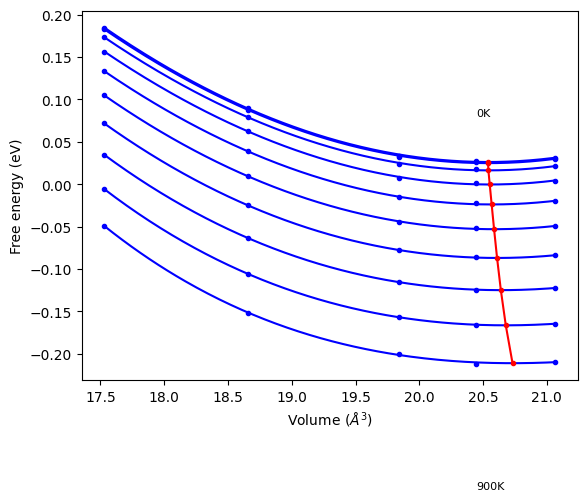

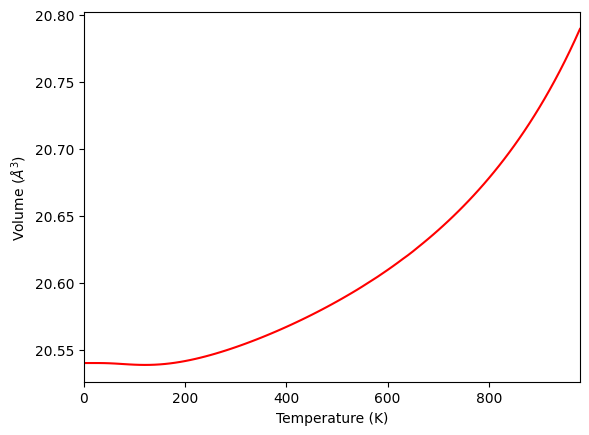

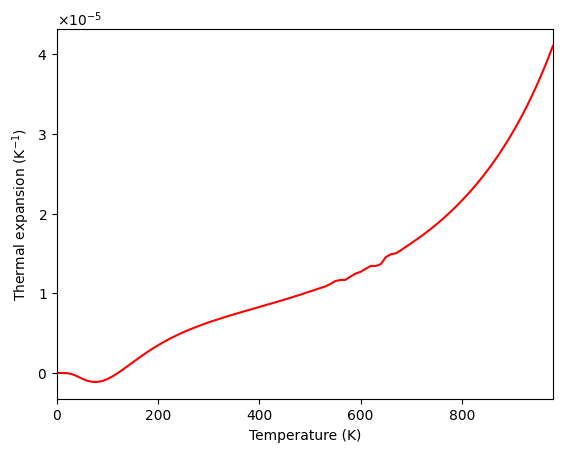

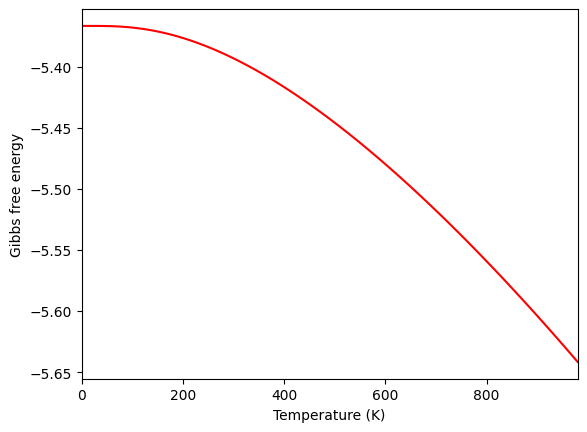

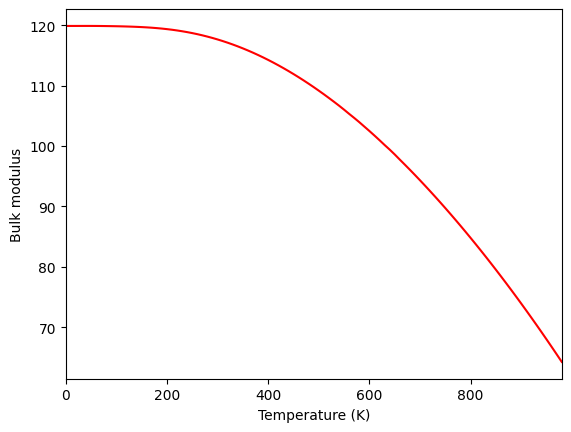

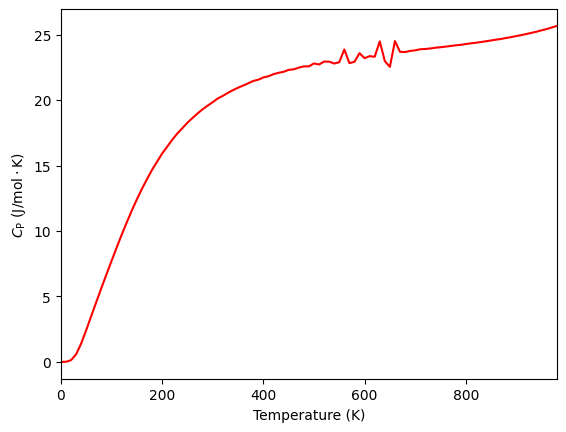

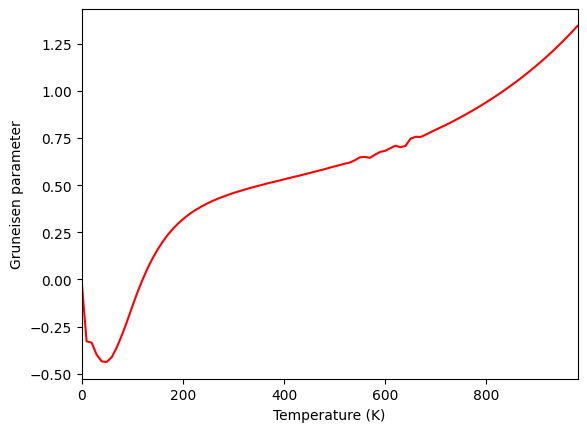

In [5]:
with mock_vasp(ref_paths=ref_paths) as mf:
    run_locally(
        flow,
        create_folders=True,
        ensure_success=True,
        raise_immediately=True,
        store=job_store,
    )

In [6]:
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.dos import PhononDos
from pymatgen.phonon.plotter import PhononBSPlotter, PhononDosPlotter

job_store.connect()

result = job_store.query_one(
    {"name": "analyze_free_energy"},
    properties=[
        "output.helmholtz_volume",
        "output.temperatures",
        "output.volumes",
    ],
    load=True,
    sort={"completed_at": -1},  # to get the latest computation
)

You can then plot some of the output free energy volume curves

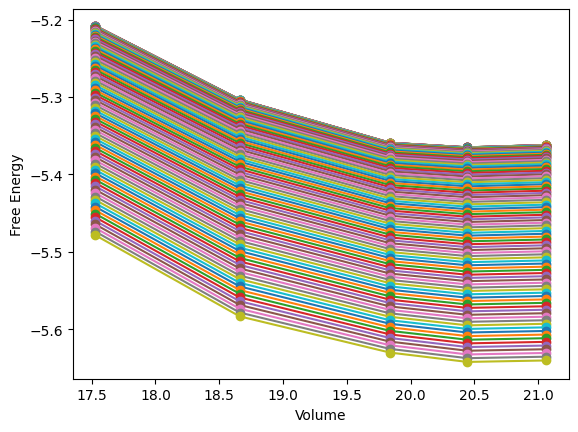

In [7]:
import matplotlib.pyplot as plt

for temp, energy_list in zip(result["output"]["temperatures"], result["output"]["helmholtz_volume"]):


    # Create the plot
    plt.plot(result["output"]["volumes"], energy_list, marker='o')
    # Add labels and title
plt.xlabel('Volume')
plt.ylabel('Free Energy')

# Show the plot
plt.show()
